# Final Project Submission 4/5
 - Student name: Morgan Jones
 - Student pace: Full Time
 - Scheduled project review date/time: Mon, Jun 22, 2020, 4:00 PM - 4:45 PM France; Paris (GMT+2:00) [DST]
 - Instructor name: Abhineet Kulkarni
 - Blog post URL: https://medium.com/@morganjonesartist/the-ai-models-that-could-increase-diversity-inclusion-in-media-132cf19858cf
 ***

# Introduction

## Business Case

Having successfully generated high resolution images of faces, the last functionality that needs to be demonstrated is mapping these faces to a video source. In this hypothetical business case the original video source will be in the form of a television show or movie being streamed on the Netflix platform. **First Order Motion Models will enable the viewer to imbue a new cast into the original video source that is animated to identically match the movement and gestures from the source.**

# First Order Motion Model

Much like the GANs from our previous notebooks, the First Order Motion Model relies on two unique data inputs, that of the source image and the driving video. For our purposes the source image is the face image produced by the StyleGAN2 model created in the previous notebook, and the driving video is a video source being streamed on Netflix. Due to the formating differences between the square GAN images and HD shape of Netflix streams, the examples of driving video is of my own creation.

First Order Motion Models were introduced by Aliaksandr Siarohin et al. in their *First Order Motion Model for Image Animation* (http://papers.nips.cc/paper/8935-first-order-motion-model-for-image-animation.pdf). The power for the business case stated from the FOMM is the ability to create a video sequence that animates a source image based on motion of the driving video without the use of premade annotations or information shared about the objects to be mapped. The motion First Order Motion models are able to capture include facial expressions, head poses, and eye movements. While other frameworks required landmark detectors, and were object specific, the FOMM can animate multiple object categories, does not require an object model, and learns to only transfer motion.

This is achieved by training the Model on a video data featuring the object to be mapped, then decoupling appearance and motion information using the self-supervised Monkey-Net model. An occlusion-aware generator model then generates the portions of the source image that are not initially present to match the driving video. In order to improve the transformations of the source image object to the motions of the driving video, keypoint detector training is conducted. What is impactful from this framework is the fact that it is able to map to a variety of object categories, a function that is necessary for the business case.

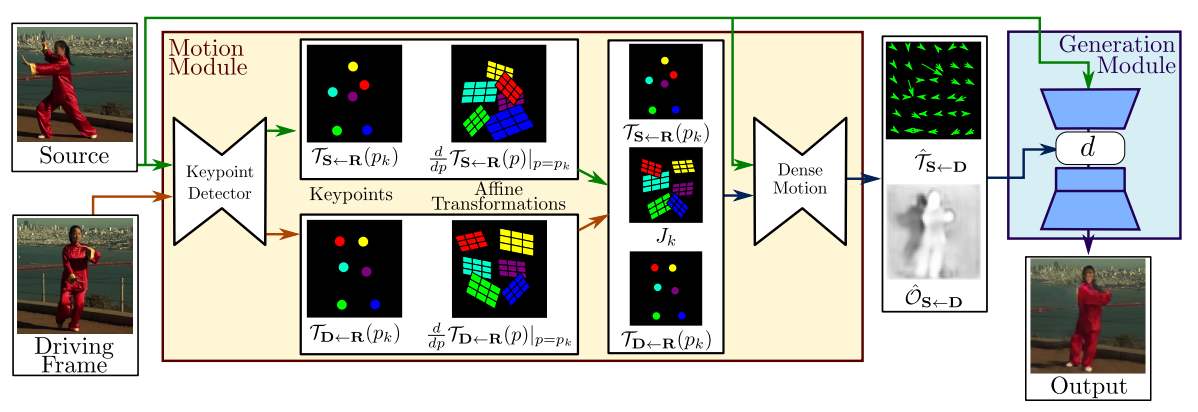

In [1]:
# View image
from IPython.display import Image
Image(filename='imgs/notebook_images/fomm_architecture.PNG') 

# Import Libraries

Just as in the previous notebooks, we will use Google CoLab to conduct our work for this notebook. Therefore we will connect CoLab to our Google drive with the following `.mount()` call

In [3]:
# Connect CoLab to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


For accessing the pretrained First Order Motion Model, we will need to clone the model and checkpoints from the First Order Model repository on GitHub with the following call.

In [1]:
# Clone the github repo
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...


We will also need to add the following folder provided by the First Order Motion Model team. This folder contains sample driving videos and source images, as well as the checkpoint path files for loading in the pretrained model. The folder can be found at this link: https://drive.google.com/drive/folders/1kZ1gCnpfU0BnpdU47pLM_TQ6RypDDqgw?usp=sharing.

In [ ]:
# Access the cloned directory
cd first-order-model

With the necessary paths and installments in place we will move on to importing the libraries used for this notebook. These will be the following:

* `imageio`: Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats.
* `numpy`: Library for support with large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
* `matplotlib`: Matplotlib is a 2D plotting library which can be used to generate publication quality figures. We import the animation class from matplotlib as well for showing the animations made from the FOMM.
* `resize`: From the skimage library in order to resize the source image and or driving video to match one another's resolution dimensions.
* `HTML`: From the IPython.display module to embed HTML into an IPython output for viewing the image and video in a video format.
* `warnings`: In order to remove warnings from any cells.

In [ ]:
# Import necessary libraries
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

% matplotlib inline

# Implement First Order Motion Model

##### VoxCeleb Dataset

As in the case of the StyleGAN2 instance, we will use a pretrained First Order Motion Model to animate the our generated face images. This pretrained model used the VoxCeleb dataset which is comprised of face data from 22,496 videos scraped from YouTube. This particular formation of the VoxCeleb dataset contains 12,331 training videos and 444 test videos after preprocessing, which involved extracting initial bounding boxes aroung the faces within the video much like was achieved in the first notebook. The videos have all been resized to 256x256 dimensions. The distributions of country origin of the faces within these videos are shown below.

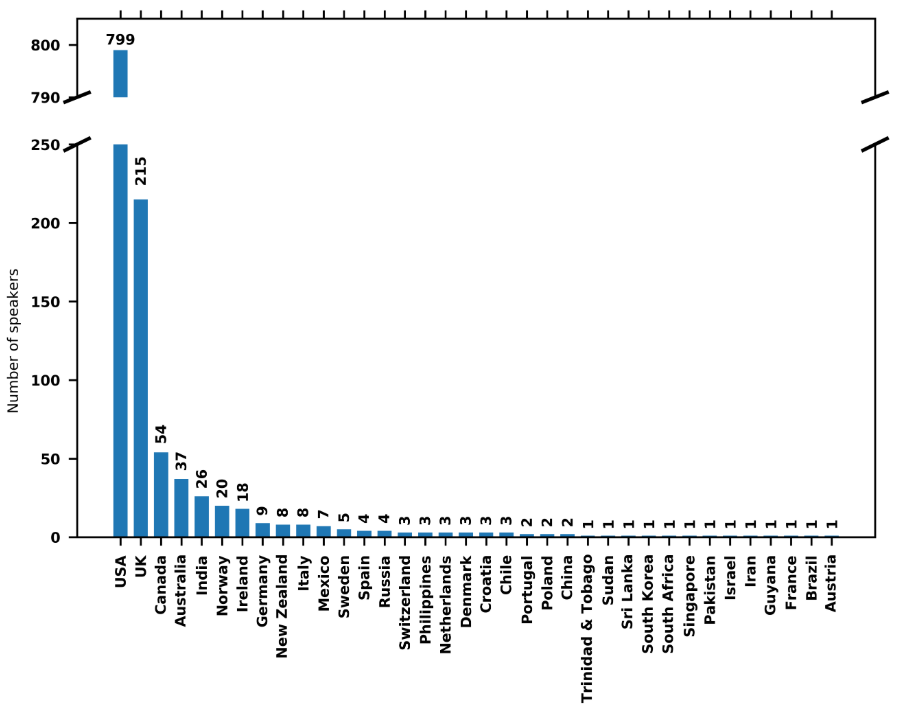

In [2]:
# View image
Image(filename='imgs/notebook_images/voxceleb_dist.PNG') 

The first step in generating our animations will be to load in the two inputs for the FOMM, our source image and driving video. The source image file will be read in using `.imread()`, while the driving video will be read in with `.mimread()` and accessed from the folder previously downloaded to Google Drive. For this instance, the source image will be one sourced from our GAN, and the driving video will be of myself, recorded on webcam locally.

In [ ]:
# Create input objects
source_image = imageio.imread('/content/gdrive/My Drive/first-order-motion-model/Copy of image299.png')
driving_video = imageio.mimread('/content/gdrive/My Drive/first-order-motion-model/me.mp4')

Next we will change the size of the two inputs so that they match each other. We set the dimensions to 256x256 in order to match the dimensions that the FOMM was trained on. This is not a requirement to generate the mapping, but yields the results we are looking for in the business case.

In [ ]:
#Resize inputs to 256x256
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

Next we will create a `display` function which will display the source still image and the driving video to confirm they are the appropriate files through a visual check. This function will take in the two inputs, display the source image, along side the driving video and output the images as an HTML5 video.

In [4]:
# Create display function
def display(source, driving, generated=None):
    """Show the source image and the driving video"""
    # Create plot for the images
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))
    
    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    
# Display images
HTML(display(source_image, driving_video).to_html5_video())

Having accessed and confirmed the appropriate inputs, it is now time to create the model and load in the checkpoints. We will use the `load_checkpoints` module from the `demo` script to access the checkpoints. We will set the `vox-cpk.pth.tar` file as the chekpoint path to be used for the generator, and the `vox-256.yaml` file as the config_path from the folder previously downloaded for the keypoint detector.

In [0]:
# Import load_checkpoints module
from demo import load_checkpoints
# Set the generator and keypoint detector
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                            checkpoint_path='/content/gdrive/My Drive/first-order-motion-model/vox-cpk.pth.tar')

With the pretrained model loaded in along, we are able to perform image animation for the still source image. We import `make_animation` from the `demo` library in order to allow the generator and kp_detector display the predictions of the appearance of the source image mapped onto the driving video. We import `img_as_ubyte` to access each frame of the driving video in order to detect the keypoints in each frame and generate the source image animated to the state of the frame, and save each of these frames sequentially as an mp4 file.

In [10]:
# Import module for creating the new animation
from demo import make_animation
from skimage import img_as_ubyte

# Generate new animation
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

#save resulting video
imageio.mimsave('../generated.mp4', [img_as_ubyte(frame) for frame in predictions])

# Display the video
HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 211/211 [00:27<00:00,  7.61it/s]


<img src='imgs/notebook_images/fomm_1.gif'>

Here we can see with the use of relative keypoint displacement we are able to animate the image generated by StyleGAN2. This successfully demonstrates the business case for the Netflix platfrom of imputing new casts into original television show and movie driving video. To further demonstrate the functionality we can use an example of faces with differing genders, through the same methods above.

In [13]:
# Create input objects
source_image = imageio.imread('/content/gdrive/My Drive/first-order-motion-model/Copy of image150.png')
driving_video = imageio.mimread('/content/gdrive/My Drive/first-order-motion-model/08.mp4', memtest=False)


# Resize inputs
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

# Generate new animation
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True,
                             adapt_movement_scale=True)

# Display the video
HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 150/150 [00:20<00:00,  7.48it/s]


<img src='imgs/notebook_images/fomm_2.gif'>

# Conclusion

In this section we completed the following tasks:

* Briefly review the flow of First Order Motion Models.
* Clone the First Order Motion Model repository from GitHub.
* Retrieve source images from StyleGAN2 and create driving video
* Feed these inputs to FOMM to animate the source image mapped to driving video

With the First Order Motion Model in this notebook we have completed the process of animating face images generated by a GAN with original video content. This work demonstrates that with the combination of models StleGAN2 and First Order Motion Model, users of the Netflix streaming platform can be offered an unprecedented range of freedom in the media they consume on the platform.

In the next and final notebook, we will explore the implications of such freedom of choice through data analysis and hypothesis testing.